In [92]:
from pyspark.sql import SparkSession
spark:SparkSession = SparkSession.builder \
    .master("local[4]") \
    .appName("k-meansKafkaa") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate() 
    


In [93]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import pyspark
from pyspark.ml.feature import StandardScaler
from kafka import KafkaConsumer
from pyspark.sql import Row

from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import VectorAssembler
import os, tempfile
from kafka import KafkaConsumer, TopicPartition
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pykafka import KafkaClient
from pykafka.common import OffsetType
from pyspark.ml.clustering import KMeansModel


In [94]:
path = "/home/adar/project/bigdataKafka/uber-raw-data-aug14.csv"
dff = spark.read.csv(path,inferSchema=True,header=True)
df1 = dff
df1.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [144]:
for m in df2.columns:
  df2.groupBy(m).count().show()

+-------+-----+
|    Lat|count|
+-------+-----+
|40.7151|  756|
|40.6956|  273|
|40.7554| 1324|
| 40.735|  781|
|40.7979|   58|
|40.6778|  219|
| 40.691|  228|
|40.6799|  159|
|40.6366|   23|
|40.6429|   73|
|41.0354|    2|
|40.8931|   14|
|40.3427|    1|
|40.8872|   18|
|40.9055|    6|
|40.8495|   16|
|41.0444|    3|
| 40.651|   20|
| 40.598|    4|
|40.9912|    3|
+-------+-----+
only showing top 20 rows

+--------+-----+
|     Lon|count|
+--------+-----+
|-73.9549|  556|
|-73.9966| 1034|
|-74.0455|    8|
|-73.9815| 1455|
|-73.8585|   23|
|-73.9999| 1195|
|-74.0467|   16|
|-73.9386|  186|
|-73.9515|  500|
|-73.8909|   31|
|-73.8445|   43|
|-73.8641|   43|
|-74.1883|    2|
|-74.0661|    5|
|-73.9011|   54|
|-73.8241|    8|
|-73.7207|    3|
|-73.8828|   22|
|-73.7072|    4|
| -73.822|    9|
+--------+-----+
only showing top 20 rows



In [95]:
numeric_cols = [col_name for col_name , col_type in dff.dtypes if col_type in ['int','double','float']]
cat_cols = [col_name for col_name , col_type in dff.dtypes if col_type  not in ['int','double','float']]
     


In [96]:
df2 = df1
df2 = df2.select(['Lat','Lon'])

In [97]:
df2.describe().toPandas()

,summary,Lat,Lon
0,count,829275,829275
1,mean,40.737780735824096,-73.97016031316342
2,stddev,0.043628060846870244,0.061482728345169296
3,min,39.6569,-74.7737
4,max,41.3182,-72.3359


<AxesSubplot:>

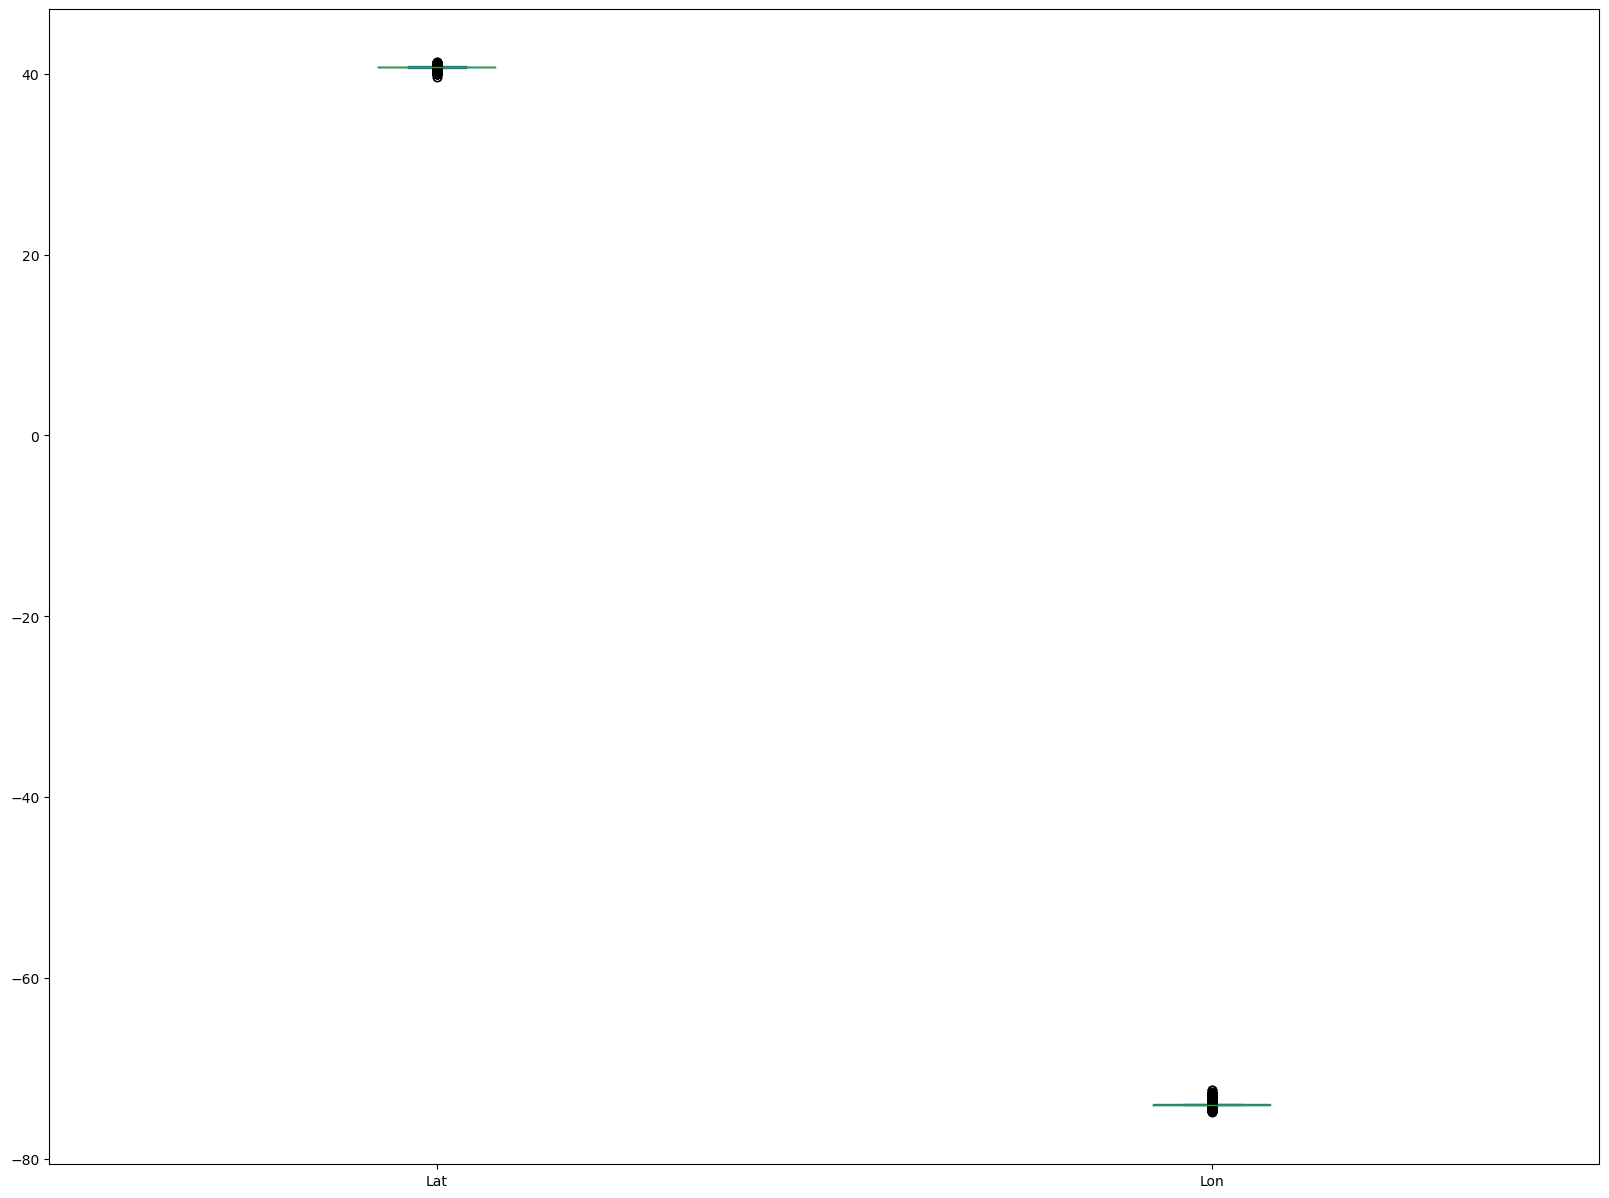

In [98]:
df2_p = df2.toPandas()
df2_p.plot.box(figsize=(20,15))

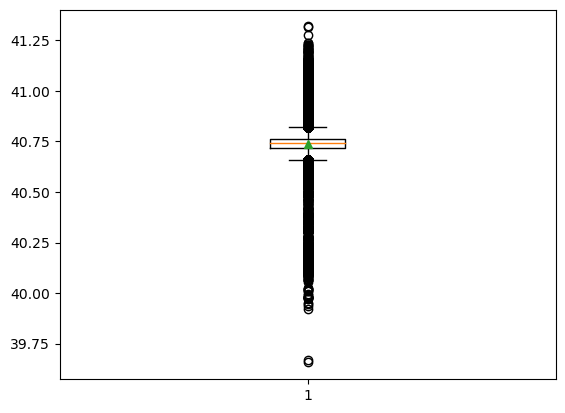

In [99]:
bp_lat = plt.boxplot(df2_p['Lat'], showmeans=True,showcaps=True)


In [100]:
[item.get_ydata() for item in bp_lat['caps']]

[array([40.6568, 40.6568]), array([40.8227, 40.8227])]

In [101]:
df2.filter((df2.Lat>40.8227) | (df2.Lat<40.6568)).count()

52544

In [102]:
df2_in= df2

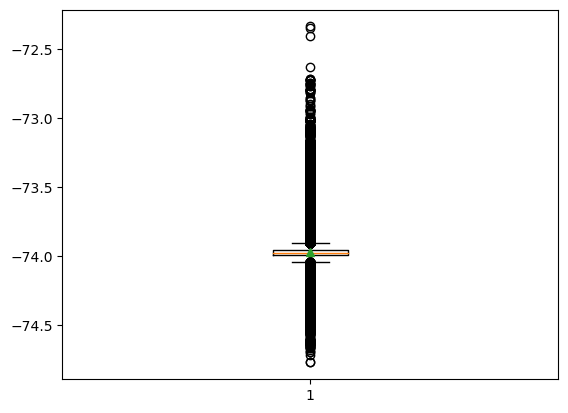

In [103]:
bp_lon = plt.boxplot(df2_p['Lon'], showmeans=True,showcaps=True)


In [104]:
[item.get_ydata() for item in bp_lon['caps']]

[array([-74.0476, -74.0476]), array([-73.9093, -73.9093])]

In [105]:
df2_in.filter((df2_in.Lon>-73.9093) | (df2_in.Lon<-74.0476)).count()

80772

In [106]:
dfSc = df2_in

In [122]:
train_data, test_data = df2_in.randomSplit([0.8,0.2],seed=70)


In [124]:
test_data.repartition(1).write.csv("testData5.csv", header=True)

In [125]:
vec_assembeled = VectorAssembler(inputCols=train_data.columns,outputCol='feature_vectored')
df2_vectored= vec_assembeled.transform(train_data)

     

In [126]:
vec_assembeled2 = VectorAssembler(inputCols=dfSc.columns,outputCol='feature_vectored')
df2_vectored2= vec_assembeled2.transform(dfSc)


In [127]:
df2_vectored=df2_vectored.select('feature_vectored')

In [128]:

scaler = StandardScaler(inputCol='feature_vectored', outputCol='feature_sacled',
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df2_vectored)
scaledData = scalerModel.transform(df2_vectored)

In [129]:

scaler2 = StandardScaler(inputCol='feature_vectored', outputCol='features',
                        withStd=True, withMean=False)
scalerModel2 = scaler2.fit(df2_vectored2)
scaledData3 = scalerModel2.transform(df2_vectored2)

In [130]:
scaledData3 = scaledData3.select('features')

In [131]:
scaledData = scaledData.select('feature_sacled')
scaledData.show(5)

+--------------------+
|      feature_sacled|
+--------------------+
|[915.578300874925...|
|[916.885627680551...|
|[916.892508347949...|
|[917.007186137916...|
|[917.018653916913...|
+--------------------+
only showing top 5 rows



In [132]:
Sc_df =scaledData
Sc_df= Sc_df.withColumnRenamed("feature_sacled", "features")
Sc_df.show(5)

+--------------------+
|            features|
+--------------------+
|[915.578300874925...|
|[916.885627680551...|
|[916.892508347949...|
|[917.007186137916...|
|[917.018653916913...|
+--------------------+
only showing top 5 rows



In [133]:
silhouette_scores = []
k_values=[2,3,4,5,6,7,8,9,10]    

for k in k_values:
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(scaledData3)

    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(model.transform(scaledData3))
    silhouette_scores.append(silhouette_score)
    

 
    
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

print(best_k)



2


In [136]:
kmeans3 = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model56 = kmeans.fit(Sc_df)

In [137]:
model_path3 ="/home/adar/project/bigdataKafka/model56"
model56.save(model_path3)

In [138]:
client = KafkaClient(hosts="localhost:9092")


topic = client.topics['test_topic100']
try:
    client.topics.create_topic(topic_name="test_topic100", partitions=1, replication_factor=1)
except :
    pass
df = spark.read.csv("/home/adar/project/bigdataKafka/testdata21.csv", header=True)
data = [str(row) for row in df.collect()]


with topic.get_producer() as producer:
    for msg in data:
        print(msg)
        producer.produce(msg.encode("ascii"))


Row(Lat='39.6569', Lon='-74.2258')
Row(Lat='39.9701', Lon='-74.0662')
Row(Lat='39.9776', Lon='-74.0651')
Row(Lat='39.9803', Lon='-74.067')
Row(Lat='39.9827', Lon='-74.0681')
Row(Lat='39.9947', Lon='-74.0634')
Row(Lat='40.0626', Lon='-74.0569')
Row(Lat='40.0937', Lon='-74.0369')
Row(Lat='40.0944', Lon='-74.0369')
Row(Lat='40.1038', Lon='-74.0352')
Row(Lat='40.1077', Lon='-74.0526')
Row(Lat='40.1103', Lon='-74.0358')
Row(Lat='40.1109', Lon='-74.0389')
Row(Lat='40.112', Lon='-74.0343')
Row(Lat='40.1187', Lon='-74.0435')
Row(Lat='40.1362', Lon='-74.0625')
Row(Lat='40.1362', Lon='-74.0293')
Row(Lat='40.1365', Lon='-74.0281')
Row(Lat='40.1377', Lon='-74.0424')
Row(Lat='40.1464', Lon='-74.0415')
Row(Lat='40.1511', Lon='-74.0389')
Row(Lat='40.1637', Lon='-74.0246')
Row(Lat='40.1659', Lon='-74.0199')
Row(Lat='40.1728', Lon='-74.0275')
Row(Lat='40.175', Lon='-74.0289')
Row(Lat='40.1752', Lon='-74.0161')
Row(Lat='40.1753', Lon='-74.027')
Row(Lat='40.1778', Lon='-74.0298')
Row(Lat='40.186', Lon='-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [140]:

consumer = KafkaConsumer(
    'test_topic100',
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True
)
rows2=[]
rows=[]
col_names=['Lat','Lon']
for msg in consumer:
    
   
   
    end_offsets = consumer.end_offsets(consumer.assignment())
    if all(consumer.position(tp) == end_offsets[tp] for tp in end_offsets):
        print("Topic is empty, breaking out of loop")
        break
    
    
    string = msg.value.decode()
    
    split_string = string.split("'")

    Lat = float(split_string[1])
    Lon = float(split_string[3])
    rows.append([Lat, Lon])    
    new_data2 = spark.createDataFrame(rows, col_names) 
    
    
    model5 = KMeansModel.load("/home/adar/project/bigdataKafka/model56")
    assembler5 = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
    new_data2 = assembler5.transform(new_data2)
    predictions5 = model5.transform(new_data2)


    rows_rdd = predictions5.rdd
    rows_list = rows_rdd.map(lambda row: list(row.asDict().values())).collect() 
    rows2.append(rows_list)
    predictions5.show(5)
    rows=[]
   
    


+-------+--------+------------------+----------+
|    Lat|     Lon|          features|prediction|
+-------+--------+------------------+----------+
|39.6569|-74.2258|[39.6569,-74.2258]|         2|
+-------+--------+------------------+----------+

+-------+--------+------------------+----------+
|    Lat|     Lon|          features|prediction|
+-------+--------+------------------+----------+
|39.9701|-74.0662|[39.9701,-74.0662]|         2|
+-------+--------+------------------+----------+

+-------+--------+------------------+----------+
|    Lat|     Lon|          features|prediction|
+-------+--------+------------------+----------+
|39.9776|-74.0651|[39.9776,-74.0651]|         2|
+-------+--------+------------------+----------+

+-------+-------+-----------------+----------+
|    Lat|    Lon|         features|prediction|
+-------+-------+-----------------+----------+
|39.9803|-74.067|[39.9803,-74.067]|         2|
+-------+-------+-----------------+----------+

+-------+--------+--------

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/adar/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/adar/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 